<font color='darkblue' size=7> Multi Arm Bandit Example </font>

In the multi-armed bandit (MAB) problem we try to maximise our gain over time by "gambling on slot-machines (or bandits)" that have different but unknown expected outcomes.

The concept is typically used as an alternative to A/B-testing used in marketing research or website optimization. For example, testing which marketing email leads to the most newsletter signups, or which webshop design leads to the most sales.

The benefit of viewing website optimization as a multi-armed bandit problem instead of an A/B-testing problem is that no pre-defined sample sizes are needed and the algorithm will start optimizing the outcome (e.g. click rate) from the beginning. While the A/B-test needs to run all predefined samples to make a conclusion.

What follows will illustrate how to implement and solve a very simple multi-armed bandit problem with a probabilistic algorithm.




https://peterroelants.github.io/posts/multi-armed-bandit-implementation/

https://gommt-my.sharepoint.com/personal/mmt7265_go-mmt_com/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fmmt7265%5Fgo%2Dmmt%5Fcom%2FDocuments%2FMicrosoft%20Teams%20Chat%20Files%2Fbandit%5Falgorithms%5Ffor%5Fwebsite%5Foptimization%20%283%29%2Epdf&parent=%2Fpersonal%2Fmmt7265%5Fgo%2Dmmt%5Fcom%2FDocuments%2FMicrosoft%20Teams%20Chat%20Files&or=teams&originalPath=aHR0cHM6Ly9nb21tdC1teS5zaGFyZXBvaW50LmNvbS86YjovZy9wZXJzb25hbC9tbXQ3MjY1X2dvLW1tdF9jb20vRVpqalZEUmNvWXhLc25qMnBnbDhpbmdCQWQ4cFhDYUkyTFBkX2JEVVhWTktoUT9ydGltZT1tUE04TmVJdjJVZw



In [1]:
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
import pickle
import sklearn
import scipy
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import yaml
import random
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<font color='darkblue' size=5> Definition of MAB </font>

-----------

**Assume there are 3 options to choose from .** 
- Each option is called a "Arm" (slot, arm, discount %, ensemble weight vectors etc)
- Each option with a different probability of outcome 
    - (click through rate or booking/sale/purchase probability or profit)  


<font color='darkblue' size=4> What can the organization do? </font>

- Pick one at random (33%/33%/33% chance)
- Test for some time and just pick 1 option which is "best". Can we? 
    - Do market conditions stay "fixed"? No.
    - Does competition stay put? No. 
    - Do consumer preferences stay static, absolutely not. 


<font color='darkblue' size=4> Solution: Learn while experimenting - Multi-arm Bandits (Thompson Sampling) </font>

In [2]:
nb_bandits = 3  # Number of bandits
# True probability of winning for each bandit
p_bandits = [0.45, 0.55, 0.60]


def pull(i):
    """Pull arm of bandit with index `i` and return 1 if win, 
    else return 0."""
    if np.random.rand() < p_bandits[i]:
        return 1
    else:
        return 0

<font size=5 color ='darkblue'> GOAL:: Maximize reward / Minimize regret </font>

The more we pull the arm of our percieved best bandit the more certain we become of the probability of that bandit. But other bandits that we haven't pulled that often might have a lower expected probability but with higher uncertainty. There is a chance that they are actually better than our percieved best bandit.

What sampling methods can we use? 
- Epsilon greedy
- Upper confidence bound
- Thompson sampling 

We'll use Thompson sampling 

We will start with the prior Beta(α=1,β=1), which corresponds to a uniform prior between 0 and 1. The run is simulated for 1000 steps and the results at certain steps are plotted below.


In [3]:
# Iterations to plot
plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000]


def plot(priors, step, ax):
    """Plot the priors for the current step."""
    plot_x = np.linspace(0.001, .999, 100)
    for prior in priors:
        y = prior.pdf(plot_x)
        p = ax.plot(plot_x, y)
        ax.fill_between(plot_x, y, 0, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_ylim(bottom=0)
    ax.set_title(f'Priors at step {step:d}')
#

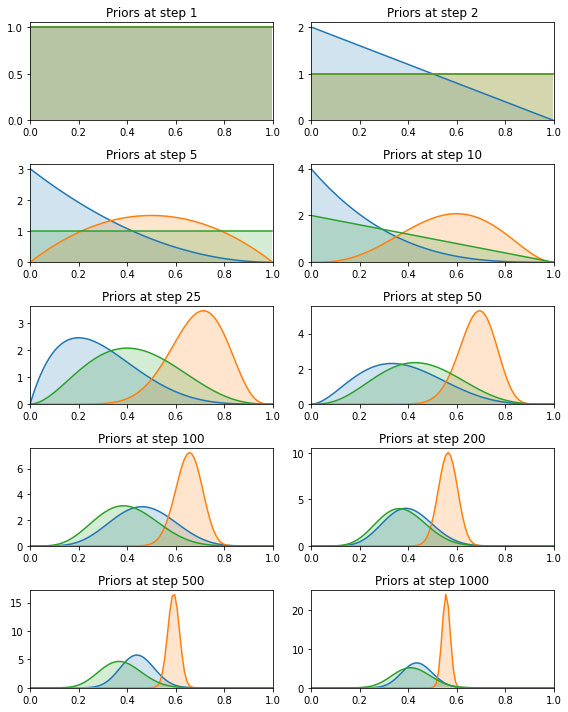

In [4]:
# Simulate multi-armed bandit process and update posteriors

# Setup plot
fig, axs = plt.subplots(5, 2, figsize=(8, 10))
axs = axs.flat

# The number of trials and wins will represent the prior for each
#  bandit with the help of the Beta distribution.
trials = [0, 0, 0]  # Number of times we tried each bandit
wins = [0, 0, 0]  # Number of wins for each bandit

n = 1000
# Run the trail for `n` steps
for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # plot prior 
    if step in plots:
        plot(bandit_priors, step, next(axs))
    # Sample a probability theta for each bandit
    theta_samples = [d.rvs(1) for d in bandit_priors]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x

plt.tight_layout()
plt.show()

### epsilon greedy

In [5]:
class EpsilonGreedy():
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
    
    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
    
    def ind_max(x):
        m = max(x)
        return x.index(m)
    
    def select_arm(self):
        if random.random() > self.epsilon:
            m = max(self.values)
            return self.values.index(m)
        else:
            return random.randrange(len(self.values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

### Thompson sampling

In [6]:
from scipy.stats import beta

class ThompsonSampling():
    def __init__(self, counts, values, alpha, beta):
        self.counts = counts
        self.values = values
        
        # Beta parameters
        self.alpha = alpha
        self.beta = beta

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        # Uniform distribution of prior beta (A,B)
        self.alpha = [1 for arm in range(n_arms)]
        self.beta = [1 for arm in range(n_arms)]
    
    # Thompson Sampling selection of arm for each round
    def select_arm(self):
        n_arms = len(self.counts)
        
        # Pair up all beta params of a and b for each arm
        beta_params = zip(self.alpha, self.beta)
        
        # Perform random draw for all arms based on their params (a,b)
        all_draws = [beta.rvs(i[0], i[1], size = 1) for i in beta_params]
        
        # return index of arm with the highest draw
        return all_draws.index(max(all_draws))
    
    # Choose to update chosen arm and reward
    def update(self, chosen_arm, reward):
        # update counts pulled for chosen arm
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]
        
        # Update average/mean value/reward for chosen arm
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        
        # Update a and b
        
        # a is based on total counts of rewards of arm
        self.alpha[chosen_arm] = self.alpha[chosen_arm] + reward
        
        # b is based on total counts of failed rewards on arm
        self.beta[chosen_arm] = self.beta[chosen_arm] + (1-reward)

In [7]:
def test_algorithm(algo, arms, num_sims, horizon):
    
    # Initialise variables for duration of accumulated simulation (num_sims * horizon_per_simulation)
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims *horizon)]
    times = [0.0 for i in range (num_sims*horizon)]
    
    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim -1) * horizon + t -1
            sim_nums[index] = sim
            times[index] = t
            
            # Selection of best arm and engaging it
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            # Engage chosen Bernoulli Arm and obtain reward info
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

### simulation

In [8]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p
    
    # Reward system based on Bernoulli
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

### Epsilon greedy

In [9]:
def simulate(algo):
    means = [0.1, 0.1, 0.1, 0.1, 0.9]
    n_arms = len(means)
    random.shuffle(means)
    arms = list(map(lambda mu: BernoulliArm(mu), means))
    algo.initialize(n_arms)
    results = test_algorithm(algo, arms, 500, 250)
    df = pd.DataFrame()
    df['sim_nums'] = results[0]
    df['times'] = results[1]
    df['chosen_arm'] = results[2]
    df['rewards'] = results[3]
    df['cum_rewards'] = results[4]
    df1 = df.groupby('times').agg({'cum_rewards': 'mean'})
    df1.plot(title='Cumulative Reward')
    df2 = df.pivot_table(index=['times'], columns='rewards', aggfunc='size', fill_value=0)
    df2.columns = ['penalty', 'reward']
    df2['prob_best_arm'] = df2['reward']/(df2['reward']+df2['penalty'])
    df2.plot(y='prob_best_arm', title='Probability Selecting best arm')

### Epsilon Greedy Simulation

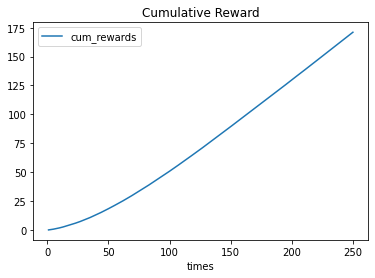

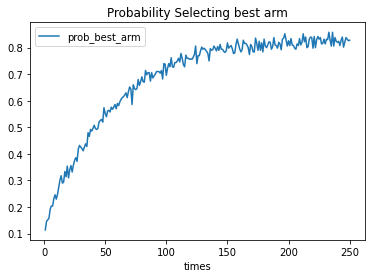

In [10]:
algo = EpsilonGreedy(0.1, [], [])
simulate(algo)

### Thompson Sampling Simulation

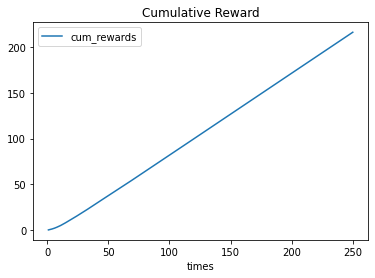

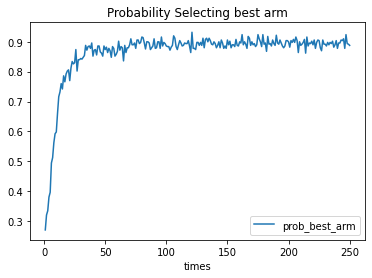

In [11]:
algo = ThompsonSampling([], [], [], [])
simulate(algo)